In [21]:
# ===========================================
# 1. Import Library dan Setup Environment
# ===========================================

import os
import json
import random
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import zipfile
import io

# Gunakan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

Device yang digunakan: cuda


In [24]:
# ===========================================
# 2. Fungsi Bantuan Umum
# ===========================================

from matplotlib.colors import ListedColormap

def seed_everything(seed=42):
    """Menetapkan seed random agar hasil eksperimen bisa direplikasi"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

def visualize_tile(x_tile, y_true=None, y_pred=None, json_path=None,class_names=None, idx=0):
    """
    Menampilkan citra tile beserta mask ground-truth dan prediksi
    """
    if isinstance(x_tile, torch.Tensor):
        x = x_tile.cpu().numpy()
        x = np.transpose(x, (1,2,0))  # ubah dari [B,H,W] -> [H,W,B]
    else:
        x = x_tile

    # menampilkan pseudo-RGB (karena data hyperspectral)
    B = x.shape[2]
    b1, b2, b3 = int(B*0.05), int(B*0.5), int(B*0.9)
    rgb = x[..., [b1, b2, b3]]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

    # Coba baca colormap dari file JSON
    if json_path and os.path.exists(json_path):
        with open(json_path, "r") as f:
            label_info = json.load(f)
        custom_colors = [c["color"][:7] for c in label_info]
        cmap = ListedColormap(custom_colors)
    else:
        print("File json tidak terbaca, menggunakan cmap tab20")
        cmap = "tab20"  # fallback

        

    # Visualisasi
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(rgb_norm); plt.title("Citra (Pseudo-RGB)")
    if y_true is not None:
        plt.subplot(1,3,2); plt.imshow(y_true, cmap=cmap); plt.title("Ground Truth")
    if y_pred is not None:
        plt.subplot(1,3,3); plt.imshow(y_pred, cmap=cmap); plt.title("Prediksi")
    plt.show()



In [3]:
# ====================================================
# 3. Dataset Loader (SeaweedDataset) dan Label Mapping
# ====================================================

def load_label_mapping(json_path):
    """Membaca file label_classes.json untuk mapping id ke nama kelas"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    idx_to_name = {i: item["name"] for i, item in enumerate(data)}
    return idx_to_name

def normalize_reflectance(cube):
    """Menormalkan nilai reflektansi ke rentang 0-1 per tile"""
    cube = np.nan_to_num(cube).astype(np.float32)
    min_val = np.nanmin(cube)
    max_val = np.nanmax(cube)
    if max_val > min_val:
        cube = (cube - min_val) / (max_val - min_val)
    return cube


class SeaweedDataset(Dataset):
    """
    Dataset hemat memori berbasis file .npy hasil konversi.
    Membaca tile langsung dari disk menggunakan mmap_mode="r".
    """
    def __init__(self, data_files, label_map, tile_size=128, normalize=True):
        self.data_files = data_files
        self.label_map = label_map
        self.tile_size = tile_size
        self.normalize = normalize

        # Daftar pasangan (file_x, file_y)
        self.pairs = []
        for f in data_files:
            if f.endswith("_x.npy"):
                fy = f.replace("_x.npy", "_y.npy")
                if os.path.exists(fy):
                    self.pairs.append((f, fy))
        
        # Hanya menyimpan indeks tile berdasarkan ukuran file .npy
        self.index = []  
        for file_idx, (fx, fy) in enumerate(self.pairs):
            x = np.load(fx, mmap_mode="r")
            H, W, _ = x.shape
            for i in range(0, H - tile_size + 1, tile_size):
                for j in range(0, W - tile_size + 1, tile_size):
                    self.index.append((file_idx, i, j))
            del x  # bebaskan referensi memori

        print(f"[INFO] Total tile terdaftar: {len(self.index)} dari {len(self.pairs)} file")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, i, j = self.index[idx]
        fx, fy = self.pairs[file_idx]
        
        # Memuat tile menggunakan mmap
        x = np.load(fx, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size, :]
        y = np.load(fy, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size]

        # Abaikan tile kosong (semua 0)
        if not np.any(y > 0):
            # Jika tile kosong, ambil tile lain secara acak agar batch tetap penuh
            return self.__getitem__(np.random.randint(0, len(self.index)))

        if self.normalize:
            x = normalize_reflectance(x)

        # Konversi ke tensor
        x_tensor = torch.tensor(x.transpose(2, 0, 1), dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        return x_tensor, y_tensor

In [4]:
# ===========================================
# 4. Load Dataset dan Splitting
# ===========================================

data_dir = "../data/npy_converted"  # lokasi data hasil konversi npz ke npy
label_json_path = "../data/annotation/segmentation_masks/label_classes.json"  # lokasi file label_classes.json

label_map = load_label_mapping(label_json_path)
print(f"Jumlah total kelas: {len(label_map)}")
print("Contoh nama kelas:", list(label_map.values())[:5])

# Ambil semua file hasil konversi (.npy)
all_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_x.npy")])
print(f"\nTotal file ditemukan: {len(all_files)}")

# Tampilkan label unik dari beberapa file pertama (cek isi mask)
for f in all_files[:3]:
    fy = f.replace("_x.npy", "_y.npy")
    if os.path.exists(fy):
        mask = np.load(fy, mmap_mode="r")
        unique_labels = np.unique(mask)
        print(f"{os.path.basename(fy)} -> Label unik: {unique_labels}")

# Buat dataset dan dataloader
dataset = SeaweedDataset(all_files, label_map, tile_size=128)

# Split train-val (80%-20%)
n = len(dataset)
idxs = list(range(n))
random.shuffle(idxs)
split = int(0.8 * n)
train_idx, val_idx = idxs[:split], idxs[split:]

train_loader = DataLoader(dataset, batch_size=4, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
val_loader   = DataLoader(dataset, batch_size=4, sampler=torch.utils.data.SubsetRandomSampler(val_idx))

num_classes = len(label_map)
print(f"\nJumlah tile train: {len(train_idx)}, val: {len(val_idx)}")


Jumlah total kelas: 41
Contoh nama kelas: ['Deep water', 'Substrate', 'Rock', 'Bedrock', 'Boulder']

Total file ditemukan: 18
massimal_smola_maholmen_202306211129-2_hsi_003_processed_y.npy -> Label unik: [ 0 13 14 18 38]
massimal_smola_maholmen_202306211129-2_hsi_004_processed_y.npy -> Label unik: [ 0 12]
massimal_smola_maholmen_202306211129-2_hsi_008_processed_y.npy -> Label unik: [ 0 12]
[INFO] Total tile terdaftar: 1778 dari 18 file

Jumlah tile train: 1422, val: 356


In [5]:
# =================================================
# 5. Model Fully Convolutional HybridSN (3D+2D CNN)
# =================================================

class FCHybridSN(nn.Module):
    def __init__(self, in_bands=300, num_classes=41):
        super().__init__()
        self.conv3d_1 = nn.Conv3d(1, 16, (7,3,3), padding=(0,1,1))
        self.bn3d_1 = nn.BatchNorm3d(16)
        self.conv3d_2 = nn.Conv3d(16, 32, (5,3,3), padding=(0,1,1))
        self.bn3d_2 = nn.BatchNorm3d(32)
        self.conv3d_3 = nn.Conv3d(32, 64, (3,3,3), padding=(0,1,1))
        self.bn3d_3 = nn.BatchNorm3d(64)

        self._out_spec = in_bands - 12
        mid_ch = 256
        self.conv2d_1 = nn.Conv2d(64 * max(1, self._out_spec), mid_ch, 3, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(mid_ch)
        self.conv2d_2 = nn.Conv2d(mid_ch, 128, 3, padding=1)
        self.bn2d_2 = nn.BatchNorm2d(128)
        self.conv2d_3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2d_3 = nn.BatchNorm2d(64)
        self.classifier = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        B, Bands, H, W = x.shape
        x3 = x.unsqueeze(1)
        x3 = F.relu(self.bn3d_1(self.conv3d_1(x3)))
        x3 = F.relu(self.bn3d_2(self.conv3d_2(x3)))
        x3 = F.relu(self.bn3d_3(self.conv3d_3(x3)))
        B, C3, out_spec, H, W = x3.shape
        x2 = x3.view(B, C3 * out_spec, H, W)
        x2 = F.relu(self.bn2d_1(self.conv2d_1(x2)))
        x2 = F.relu(self.bn2d_2(self.conv2d_2(x2)))
        x2 = F.relu(self.bn2d_3(self.conv2d_3(x2)))
        return self.classifier(x2)

model = FCHybridSN(in_bands=300, num_classes=num_classes).to(device)
print(model)


FCHybridSN(
  (conv3d_1): Conv3d(1, 16, kernel_size=(7, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_2): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_1): Conv2d(18432, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d_3): B

In [6]:
# ===========================================
# 6. Fungsi Training dan Evaluasi
# ===========================================

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

def pixel_accuracy(pred, target):
    valid = (target >= 0)
    correct = (pred[valid] == target[valid]).sum()
    total = valid.sum()
    return (correct.float() / (total.float() + 1e-9)).item()

def iou_per_class(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_i = (pred == cls)
        target_i = (target == cls)
        inter = (pred_i & target_i).sum()
        union = (pred_i | target_i).sum()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((inter.float() / union.float()).item())
    return ious



In [12]:
# ===========================================
# 7. Loop Training Utama (+ checkpoint)
# ===========================================

import os
import time
from tqdm import tqdm

START_EPOCH = 10     # default 1, akan ditimpa otomatis jika ada checkpoint, set manual jika perlu
NUM_EPOCHS = 20

best_val_acc = 0.0

checkpoint_path = "hybridsn_seg_checkpoint.pth"  # file titik checkpoint

# Pemeriksaan apakah checkpoint sebelumnya ditemukan
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    START_EPOCH = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    print(f"[INFO] Memuat model dari checkpoint: {checkpoint_path} (lanjut dari epoch {START_EPOCH})")
else:
    print("[INFO] Tidak ditemukan checkpoint. Mulai training dari awal.")

for epoch in range(START_EPOCH, NUM_EPOCHS+1):
    start_time = time.time()

    # === Mode Training ===
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=True)
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({"TrainLoss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)

    # === Mode Validasi (tidak pakai tqdm bar) ===
    model.eval()
    val_accs, val_ious = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            val_accs.append(pixel_accuracy(preds, yb))
            val_ious.extend(iou_per_class(preds, yb, num_classes))

    mean_val_acc = np.nanmean(val_accs)
    mean_iou = np.nanmean([v for v in val_ious if not np.isnan(v)])
    elapsed = time.time() - start_time

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Loss={avg_loss:.4f} | ValAcc={mean_val_acc:.4f} | mIoU={mean_iou:.4f} | Time={elapsed/3600:.2f} jam")


    # SIMPAN CHECKPOINT (checkpoint memiliki file-nya sendiri)
    # ------------------------
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc
    }
    torch.save(checkpoint, checkpoint_path)

    if mean_val_acc > best_val_acc:
        best_val_acc = mean_val_acc
        # file hybridsn_seg_best.pth ini seperti file checkpoint tetapi untuk menyimpan kondisi ketika diperoleh best_val_acc yang lebih baik
        torch.save(model.state_dict(), "hybridsn_seg_best.pth") 
        print("OK, Model terbaik disimpan.")





[INFO] Tidak ditemukan checkpoint. Mulai training dari awal.


Epoch 10/20: 100%|███████████████████████████████████████████████| 356/356 [7:53:34<00:00, 79.82s/it, TrainLoss=3.0507]


Epoch 10/20 | Loss=0.7469 | ValAcc=0.4939 | mIoU=0.2345 | Time=8.40 jam
OK, Model terbaik disimpan.


Epoch 11/20: 100%|███████████████████████████████████████████████| 356/356 [7:53:39<00:00, 79.83s/it, TrainLoss=1.3404]


Epoch 11/20 | Loss=0.7303 | ValAcc=0.5226 | mIoU=0.2823 | Time=8.40 jam
OK, Model terbaik disimpan.


Epoch 12/20:   5%|██▍                                             | 18/356 [24:01<7:31:11, 80.09s/it, TrainLoss=0.3923]


MemoryError: Unable to allocate 18.8 MiB for an array with shape (128, 128, 300) and data type float32

In [8]:
# cel darurat untuk menyimpan proses antara epoch 9 dan epoch 10

torch.save(model.state_dict(), "hybridsn_seg_manual_backup_epoch9.pth")
print("✅ Model terakhir di memori berhasil disimpan sebagai backup.")

✅ Model terakhir di memori berhasil disimpan sebagai backup.


C:\Users\admin\AppData\Local\Temp\ipykernel_10384\2811183925.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybridsn_seg_best.pth"))


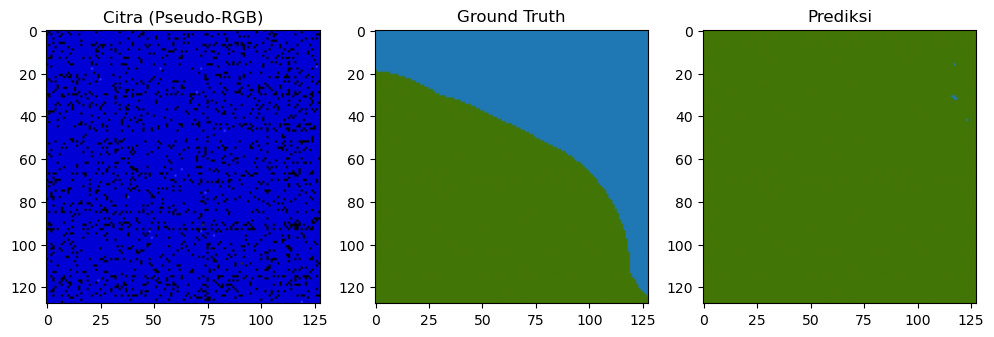

In [25]:
# ===========================================
# 8. Visualisasi Hasil Prediksi
# ===========================================

model.load_state_dict(torch.load("hybridsn_seg_best.pth"))
model.eval()
xb, yb = next(iter(val_loader))
xb, yb = xb.to(device), yb.to(device)
with torch.no_grad():
    preds = model(xb).argmax(dim=1).cpu().numpy()
yb_np = yb.cpu().numpy()
visualize_tile(xb[0], y_true=yb_np[0], y_pred=preds[0], json_path="../data/annotation/segmentation_masks/label_classes.json")


In [26]:
# ===========================================
# 9. Inferensi Citra Penuh
# ===========================================

def infer_full_image(model, cube, tile_size=128, stride=96):
    model.eval()
    H, W, B = cube.shape
    out_logits = np.zeros((num_classes, H, W), dtype=np.float32)
    count = np.zeros((H, W), dtype=np.float32)
    for i in range(0, max(1, H - tile_size + 1), stride):
        for j in range(0, max(1, W - tile_size + 1), stride):
            tile = cube[i:i+tile_size, j:j+tile_size, :]
            if tile.shape[0] < tile_size or tile.shape[1] < tile_size:
                continue
            x = torch.from_numpy(np.transpose(tile, (2,0,1))).unsqueeze(0).to(device).float()
            with torch.no_grad():
                probs = F.softmax(model(x), dim=1).cpu().numpy()[0]
            out_logits[:, i:i+tile_size, j:j+tile_size] += probs
            count[i:i+tile_size, j:j+tile_size] += 1
    count[count==0] = 1.0
    pred_map = (out_logits / count[np.newaxis,...]).argmax(axis=0)
    return pred_map

# Ambil path ke file cube (bukan mask)
p = [f for f in all_files if f.endswith("_x.npy")][0]
cube = np.load(p) 
predmap = infer_full_image(model.to(device), cube)
plt.figure(figsize=(8,6))
plt.imshow(predmap, cmap='tab20')
plt.title(f"Hasil Inferensi: {os.path.basename(p)}")
plt.show()



MemoryError: Unable to allocate 2.01 GiB for an array with shape (540000000,) and data type float32